## 임포트

In [1]:
import os
import time
import json
import random

import wandb
import timm
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torchvision.models as tv_models
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize



## 파라미터 and Wandb

In [17]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# data config
data_path = '../data/'
train_path = '../data/train/'
test_path = '../data/test/'


# 모델 이름과 weights enum 매핑
weights_mapping = {
    'resnet50': tv_models.ResNet50_Weights,
    'resnet34': tv_models.ResNet34_Weights,
    'resnet101': tv_models.ResNet101_Weights,
    'efficientnet_b0': tv_models.EfficientNet_B0_Weights,
    'efficientnet_b3': tv_models.EfficientNet_B3_Weights,

    # 필요시 다른 모델도 추가
}

# training config
CFS = {'model_name': 'resnet101',  # 'resnet34' 'efficientnet_b0', ...
       'img_size': 224,
       'num_classes': 45,  # Adjust based on your dataset
       'LR': 1e-5, # Learning rate 가 이 숫자보다 크면 학습이 잘 안되는 것 같습니다.
       'EPOCHS': 20,
       'BATCH_SIZE': 32,
       'num_workers': 16
      }

# 프로젝트 이름과 하이퍼파라미터를 지정해 run을 시작
wandb.init(
    project="upstage-DC-project",  # 원하는 프로젝트 이름
    config=CFS,  # 하이퍼파라미터 설정
    name=f"model{CFS['model_name']}_EPOCHs{CFS['EPOCHS']}_lr{CFS['LR']}_bs{CFS['BATCH_SIZE']}"

)

# 터미널에서 wandb init

cuda


f1_score,▁▁▂▁▃▄▅▅▅▅▅▅▆▆▆▇▇▇██
precision,▁▂▂▂▃▅▅▅▅▅▅▅▆▆▆▇▇▇██
recall,▁▁▂▂▃▄▅▅▅▅▅▅▆▆▆▇▇▇██
roc_auc,▁▄▅▅▅▇▇▇▇▇▇▇████████
train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▁▂▂▄▅▆▆▆▆▇▇▇▇▇█████
val_loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
f1_score,0.51791
precision,0.55042
recall,0.53676
roc_auc,0.9617


## class dictionary

In [18]:
classes_to_idx = {
            '물류선하증권': 0,
            '주민생활지원': 1,
            '개인신용정보조회동의서(계약체결)': 2,
            '모집경위서': 3,
            '학자금대출신청서': 4,
            '금융증권신고서': 5,
            '개인신용정보조회동의서(상품소개)': 6,
            '농림.축산지원': 7,
            '회계.예산': 8,
            '금융은행위임장': 9,
            '금융증권위임장': 10,
            '금융은행신고서': 11,
            '물류포장명세서': 12,
            '지역문화': 13,
            '고객확인서(변경/정정)': 14,
            '금융보험합의서': 15,
            '금융증권확인서': 16,
            '물류기타': 17,
            '상수도관리': 18,
            '계약전알릴의무사항': 19,
            '상.하수도관리': 20,
            '사실조사확인서': 21,
            '금융보험위임장': 22,
            '금융보험청구서': 23,
            '금융보험동의서': 24,
            '금융보험확인서': 25,
            '주민복지': 26,
            '지역환경.산림': 27,
            '물류상업송장': 28,
            '보험차익 세제관련 안내확인서': 29,
            '물류원산지증명서': 30,
            '인.허가': 31,
            '산업진흥': 32,
            '금융증권신청서': 33,
            '청약서': 34,
            '주민자치': 35,
            '보험계약 변경신청 위임장': 36,
            '부동산대출신청서': 37,
            '일반행정': 38,
            '금융은행신청서': 39,
            '금융보험신청서': 40,
            '은행거래신청서(계좌개설)': 41,
            '정보보안동의서': 42,
            '도시개발': 43,
            '금융은행확인서': 44
        }


## seed

In [19]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42) # Seed 고정

## transfrom

In [20]:

train_transform = transforms.Compose([
    transforms.Resize((CFS['img_size'], CFS['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((CFS['img_size'], CFS['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## label 

In [21]:

def get_label(filename):
    """
    classification.py
    """
    # print(f"get_label: {filename}")
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'images' in data and len(data['images']) > 0:
        first_image = data['images'][0]
        if 'image.category' in first_image:
            image_category = first_image['image.category']
        elif 'document_name' in first_image:
            image_category = first_image['document_name']
    else:
        dic = {0: '은행', 1: '보험', 2: '증권', 3: '기타'}
        form_type = data['Images']['form_type']
        # print(f"form_type: {form_type}")
        if "form_industry" in data['Images']:
            industry = data['Images']['form_industry']
            image_category = "금융" + dic[industry] + data['Images']['form_type']
        else:
            image_category = "물류" + data['Images']['form_type']

    # print(image_category)  # 출력: 주민자치

    return image_category

## custom image Dataset

In [22]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, path, transform=None,):
        self.path = path
        self.transform = transform
        self.samples = []
        self.classes_to_idx = classes_to_idx  # 클래스 인덱스 매핑

        label_set = set()
        for folder in os.listdir(self.path):
            folder_path = os.path.join(self.path, folder)
            if not os.path.isdir(folder_path):
                continue
            for f in os.listdir(folder_path):
                if f.lower().endswith(('.jpg', '.png')):
                    img_path = os.path.join(folder_path, f)
                    json_path = img_path.rsplit('.', 1)[0] + '.json'
                    label = get_label(json_path) # 라벨을 가져옵니다
                    self.samples.append((img_path, self.classes_to_idx[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        label = torch.tensor(label)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
            

## Dataloader

In [23]:
# 전체 데이터셋 로드
full_dataset = ImageDataset(train_path, transform=None)
print(f"원본 데이터셋 크기: {len(full_dataset)}")

targets = [label for _, label in full_dataset.samples]
print(f"클래스 수: {len(set(targets))}")
print(f"클래스 이름: {set(targets)}")

# Stratified Split
train_idx, val_idx = train_test_split(
    range(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

# Subset + transform 각각 적용
train_dataset = Subset(ImageDataset(train_path, transform=train_transform), train_idx)
val_dataset = Subset(ImageDataset(train_path, transform=test_transform), val_idx)
print(f'train 이미지 수: {len(train_dataset)}, valid 이미지 수: {len(val_dataset)}')

# DataLoader 정의
train_loader = DataLoader(
    train_dataset,
    batch_size=CFS['BATCH_SIZE'],
    shuffle=True,
    num_workers=CFS['num_workers'],
    pin_memory=True,
    drop_last=False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CFS['BATCH_SIZE'],
    shuffle=False,
    num_workers=int(CFS['num_workers'] / 2),
    pin_memory=True
)


원본 데이터셋 크기: 8662
클래스 수: 45
클래스 이름: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44}
train 이미지 수: 6929, valid 이미지 수: 1733


## Model

In [24]:
# pretrained weights enum 가져오기
weights_enum = weights_mapping.get(CFS['model_name'], None)
weights = weights_enum.DEFAULT if weights_enum is not None else None

# 모델 함수 가져오기
model_fn = getattr(tv_models, CFS['model_name'], None)

if model_fn is not None:
    model = model_fn(weights=weights)
    
    # 마지막 레이어 교체
    if CFS['model_name'].startswith('resnet'):
        model.fc = torch.nn.Linear(model.fc.in_features, CFS['num_classes'])
        model.to(device)
    elif CFS['model_name'].startswith('efficientnet'):
        # EfficientNet 계열의 구조는 버전에 따라 다를 수 있음
        if isinstance(model.classifier, torch.nn.Sequential):
            model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, CFS['num_classes'])
            model.to(device)
        else:
            # 혹시 Sequential이 아니면 직접 구조를 확인 후 수정
            print(model.classifier)
else:
    raise ValueError(f"지원하지 않는 모델명: {CFS['model_name']}")
print(model)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /data/ephemeral/home/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 117MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train

In [ ]:
print(f"training model: {CFS['model_name']}")
print("-" * 50)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=CFS['LR'])

train_losses = []
val_losses = []

for epoch in range(CFS['EPOCHS']):
    model.train()
    train_loss = 0.0
    preds_list = []
    targets_list = []
    probs_list = []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFS['EPOCHS']}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation {epoch+1}/{CFS['EPOCHS']}"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * images.size(0)
            total += images.size(0)

            preds = outputs.argmax(dim=1)
            preds_list.extend(preds.detach().cpu().numpy())
            targets_list.extend(labels.detach().cpu().numpy())

            probs = outputs.softmax(dim=1)
            probs_list.extend(probs.detach().cpu().numpy())

            correct += (preds == labels).sum().item()
        val_loss /= len(val_loader.dataset) 
        val_losses.append(val_loss)

    # accuracy, F1, Precision, Recall
    acc = accuracy_score(targets_list, preds_list)
    f1 = f1_score(targets_list, preds_list, average='macro')
    precision = precision_score(targets_list, preds_list, average='macro', zero_division=0)
    recall = recall_score(targets_list, preds_list, average='macro', zero_division=0)

    # ROC-AUC (다중 클래스)
    # y_true를 one-hot으로 변환
    target_binary_list = label_binarize(targets_list, classes=np.arange(CFS['num_classes']))
    try:
        roc_auc = roc_auc_score(np.array(target_binary_list), np.array(probs_list), average='macro', multi_class='ovr')
    except ValueError:
        roc_auc = np.nan  # 클래스가 하나만 있을 때 등 예외 처리
    
    # wandb에 로그 기록
    wandb.log({"train_loss": train_loss, "val_loss": val_loss, "val_acc": acc*100, "f1_score": f1,
        "precision": precision, "recall": recall, "roc_auc": roc_auc,
    })

    # 결과 출력
    print(f"Epoch {epoch+1} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Valid Accuracy : {acc * 100:.4f}% | "
        # f"Correct: {correct}/{total} | "
        f"F1 Score: {f1:.4f} | "
        f"Precision: {precision:.4f} | "
        f"Recall: {recall:.4f} | ")
        # f"ROC-AUC: {roc_auc:.4f}")

training model: resnet101
--------------------------------------------------


Validation 1/20: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


Epoch 1 | Train Loss: 2.9161 | Val Loss: 2.1700 | Valid Accuracy : 41.4887% | F1 Score: 0.0363 | Precision: 0.0691 | Recall: 0.0408 | 


Validation 2/20: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


Epoch 2 | Train Loss: 1.8912 | Val Loss: 1.7692 | Valid Accuracy : 51.1252% | F1 Score: 0.0953 | Precision: 0.1253 | Recall: 0.1044 | 


Validation 3/20: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


Epoch 3 | Train Loss: 1.5487 | Val Loss: 1.9063 | Valid Accuracy : 56.1454% | F1 Score: 0.1846 | Precision: 0.2145 | Recall: 0.1899 | 


Validation 4/20: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


Epoch 4 | Train Loss: 1.3516 | Val Loss: 1.3799 | Valid Accuracy : 59.0306% | F1 Score: 0.2880 | Precision: 0.3270 | Recall: 0.2893 | 


Validation 5/20: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


Epoch 5 | Train Loss: 1.2107 | Val Loss: 1.3064 | Valid Accuracy : 60.9348% | F1 Score: 0.3178 | Precision: 0.3588 | Recall: 0.3216 | 


Validation 6/20: 100%|██████████| 55/55 [01:43<00:00,  1.88s/it]


Epoch 6 | Train Loss: 1.0785 | Val Loss: 1.1933 | Valid Accuracy : 62.3774% | F1 Score: 0.3811 | Precision: 0.4059 | Recall: 0.3903 | 


Validation 7/20: 100%|██████████| 55/55 [01:43<00:00,  1.88s/it]


Epoch 7 | Train Loss: 0.9733 | Val Loss: 1.5216 | Valid Accuracy : 62.7813% | F1 Score: 0.4321 | Precision: 0.4581 | Recall: 0.4316 | 


Validation 8/20: 100%|██████████| 55/55 [01:43<00:00,  1.88s/it]


Epoch 8 | Train Loss: 0.8611 | Val Loss: 1.5237 | Valid Accuracy : 64.4547% | F1 Score: 0.5194 | Precision: 0.5748 | Recall: 0.5132 | 


Validation 9/20: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


Epoch 9 | Train Loss: 0.7682 | Val Loss: 1.8938 | Valid Accuracy : 63.9354% | F1 Score: 0.5269 | Precision: 0.5576 | Recall: 0.5198 | 


Validation 10/20: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


Epoch 10 | Train Loss: 0.6775 | Val Loss: 1.2532 | Valid Accuracy : 65.3780% | F1 Score: 0.5977 | Precision: 0.6242 | Recall: 0.5947 | 


Validation 11/20: 100%|██████████| 55/55 [01:43<00:00,  1.88s/it]


Epoch 11 | Train Loss: 0.5798 | Val Loss: 1.3191 | Valid Accuracy : 66.3589% | F1 Score: 0.6168 | Precision: 0.6874 | Recall: 0.6037 | 


Validation 12/20: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


Epoch 12 | Train Loss: 0.5076 | Val Loss: 1.2539 | Valid Accuracy : 65.7819% | F1 Score: 0.6612 | Precision: 0.7171 | Recall: 0.6420 | 


Epoch 13/20:  59%|█████▉    | 128/217 [04:16<00:19,  4.46it/s]

In [6]:
torch.cuda.empty_cache()


In [5]:

del model  # 모델 학습 후 메모리 해제  
del outputs, loss  # 학습 후 즉시 삭제

NameError: name 'model' is not defined

In [14]:
def save_model(model, optimizer, scheduler, epoch, best_logloss, no_improve, backbone_name):
    """ Save the model state, optimizer state, and scheduler state."""
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict() if scheduler else None,
        'best_logloss': best_logloss,
        'no_improve': no_improve
    }, f"best_{backbone_name}_epoch{epoch}.pth")
    print(f"✅ Best model saved (LogLoss: {best_logloss:.4f})")
# 모델 저장
save_model(model, optimizer, None, CFS['EPOCHS'], val_losses[-1], 0, CFS['model_name'])

✅ Best model saved (LogLoss: 1.0757)


## Training plot

In [15]:
val_losses

[2156.1850118637085,
 2060.3055812120438,
 2073.2042323350906,
 1921.4261521100998,
 2265.9297852516174,
 2084.957463502884,
 2479.23659157753,
 2289.458372116089,
 2456.428326368332,
 2629.4957473278046,
 2635.386373400688,
 2687.9278115034103,
 2672.167493581772,
 2496.986453294754,
 2766.2378420829773,
 2582.052932739258,
 2640.9610476493835,
 2695.7505831718445,
 2917.8947372436523,
 2888.784429550171]

## 학습곡선

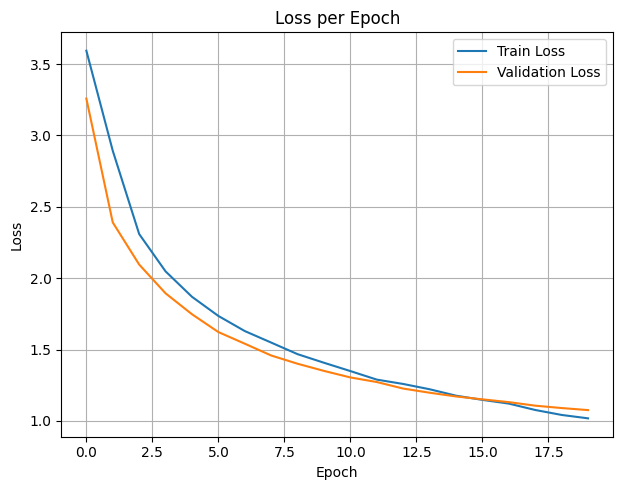

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses,):

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(train_losses, val_losses)

## inference

In [16]:
# Test dataset
test_dataset = ImageDataset(test_path, transform=test_transform)
# Test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=CFS['BATCH_SIZE'],
    shuffle=False,
    num_workers=int(CFS['num_workers'] / 2),
    pin_memory=True
)
# Inference
model.eval()
preds_list = []
targets_list = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Inference"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        preds_list.extend(preds.detach().cpu().numpy())
        targets_list.extend(labels.detach().cpu().numpy())


        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = accuracy_score(targets_list, preds_list)
    f1 = f1_score(targets_list, preds_list, average='macro')
    precision = precision_score(targets_list, preds_list, average='macro', zero_division=0)
    recall = recall_score(targets_list, preds_list, average='macro', zero_division=0)

# 결과 출력
print(f"Test Accuracy: {acc * 100:.4f}%")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")


Inference: 100%|██████████| 68/68 [02:22<00:00,  2.10s/it]

Test Accuracy: 65.2214%
Test F1 Score: 0.4954
Test Precision: 0.5127
Test Recall: 0.5218
Test ROC-AUC: 0.9617
